# Spam-Review-Analysis

## Introduction

This project seeks to employ a exercise to classify real and fake reviews. In this notebook, we shall be following the below steps:

**1. Data Exploration** -> Summary Statisctics, Class distribution, Feature distribution and Correlation between different features.

**2. Preprocessing Text** -> Punctuation Removal, Word Tokenization, Word Lemmatization, Use of n-grams, Feature vector generation.

**3. Model Training** -> Vectorization of features and Model Training - Logistic Regression and SVM for binary classification.

**4. Evaluation of Results** -> Classification Report, Confusion Matrix, Comparison of Accuracy scores for different combinations of features.

**5. Conclusion**

## Data Exploration

In [ ]:
# Import Modules
import os
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Text Cleaning and Tokenization
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
HOME_DIR = '/content/Spam-Review-Analysis/'
SCRIPT_DIR = HOME_DIR + 'scripts/'
REVIEW_TXT_PATH = HOME_DIR +'amazon_reviews.txt'

print(f"HOME_DIR: {HOME_DIR}")
print(f"SCRIPT_DIR: {SCRIPT_DIR}")
print(f"REVIEW_TXT_PATH: {REVIEW_TXT_PATH}")

HOME_DIR: /content/Spam-Review-Analysis/
SCRIPT_DIR: /content/Spam-Review-Analysis/scripts/
REVIEW_TXT_PATH: /content/Spam-Review-Analysis/amazon_reviews.txt


In [ ]:
 with open(REVIEW_TXT_PATH) as f:
        review_df = pd.read_csv(f, encoding='latin-1', delimiter = "\t")

# Drop Duplicates and modify the label names to be more readable.
review_df = review_df.drop_duplicates()
review_df.loc[review_df["LABEL"] =="__label1__", "LABEL"] = "fake"
review_df.loc[review_df["LABEL"] =="__label2__", "LABEL"] = "real"

In [ ]:
review_df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,fake,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,fake,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,fake,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,fake,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,fake,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


### Feature Distribution

#### Count of each labels

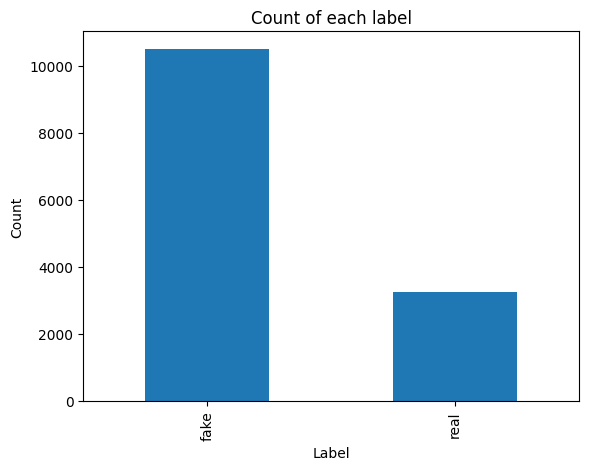

In [ ]:
ax = review_df["LABEL"].value_counts().plot(kind="bar")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Count of each label")
plt.show()

#### # `LABEL` vs `RATING`

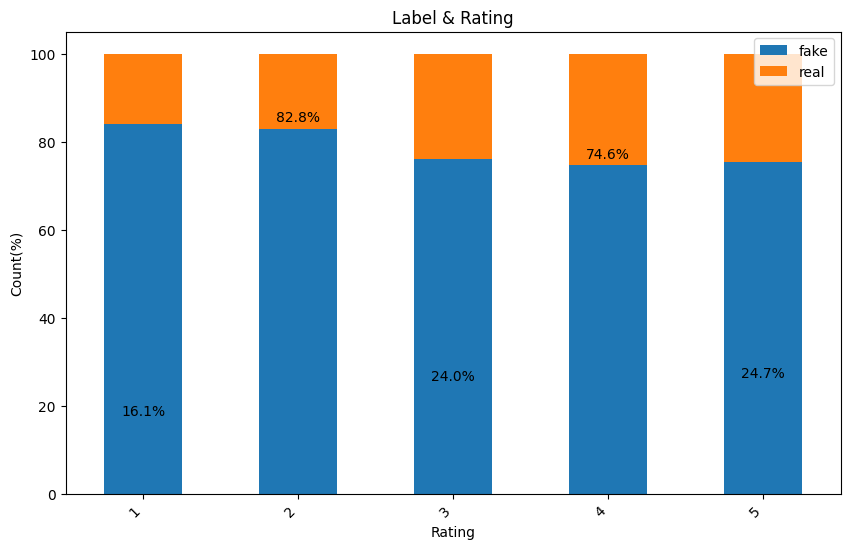

In [ ]:

label_distrubtion_by_rating = review_df.groupby("RATING")["LABEL"].value_counts().unstack(fill_value=0)
percent_label_distrubtion_by_rating = label_distrubtion_by_rating.apply(lambda x: (x/x.sum()*100), axis=1).astype(float)

ax = percent_label_distrubtion_by_rating.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_xlabel("Rating")
ax.set_ylabel("Count(%)")
ax.set_title("Label & Rating")

plt.xticks(rotation=45, ha="right")
plt.legend()

bars = ax.patches
for i, bar in enumerate(bars):
    yval = bar.get_height()
    if i % 2 != 0:  #real
        ax.text(bar.get_x() + bar.get_width() / 2,
                 yval + 1, f"{yval:.1f}%", ha='center', va='bottom')

plt.show()

#### `LABEL` vs `VERIFIED_PURCHASE`

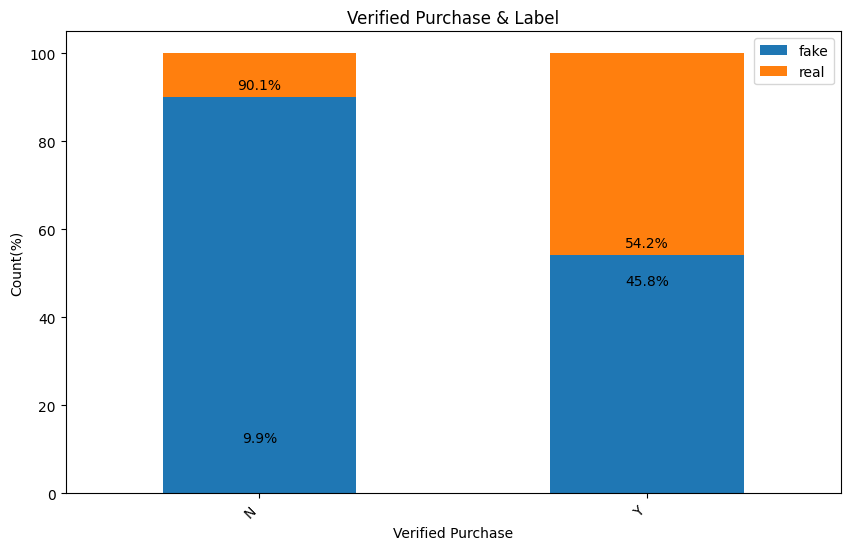

In [ ]:

label_distrubtion_by_verified_purchase = review_df.groupby("VERIFIED_PURCHASE")["LABEL"].value_counts().unstack(fill_value=0)
percent_distrubtion_by_verified_purchase = label_distrubtion_by_verified_purchase.apply(lambda x: (x/x.sum()*100), axis=1).astype(float)

ax = percent_distrubtion_by_verified_purchase.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_xlabel("Verified Purchase")
ax.set_ylabel("Count(%)")
ax.set_title("Verified Purchase & Label")

plt.xticks(rotation=45, ha="right")
plt.legend()

bars = ax.patches
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
                yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.show()

It is fairly evident that majority of the reviews with `VERIFIED_PURCHASE` as `N` is fake. This characterstics get captures in the model evaluation as `VERIFIED_PURCHASE` turns out be a good feature for classification along with the `REVIEW_TEXT`.

#### `LABEL` vs `PRODUCT_CATEGORY`

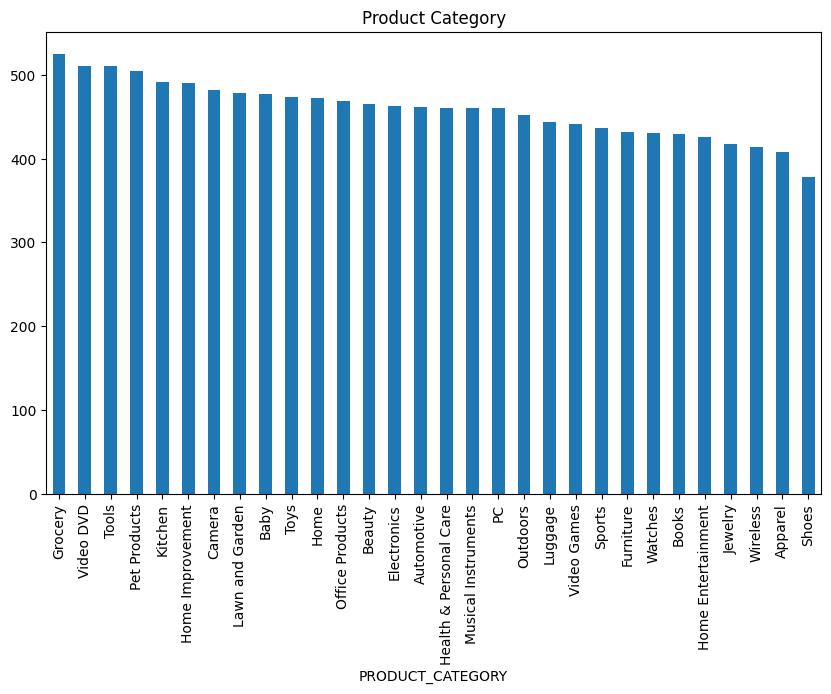

In [ ]:
# LABEL & PRODUCT_CATEGORY
review_df.PRODUCT_CATEGORY.value_counts().plot(kind="bar", figsize=(10, 6))
plt.title("Product Category")
plt.show()

#### `LABEL` vs `PRODUCT_CATEGORY`

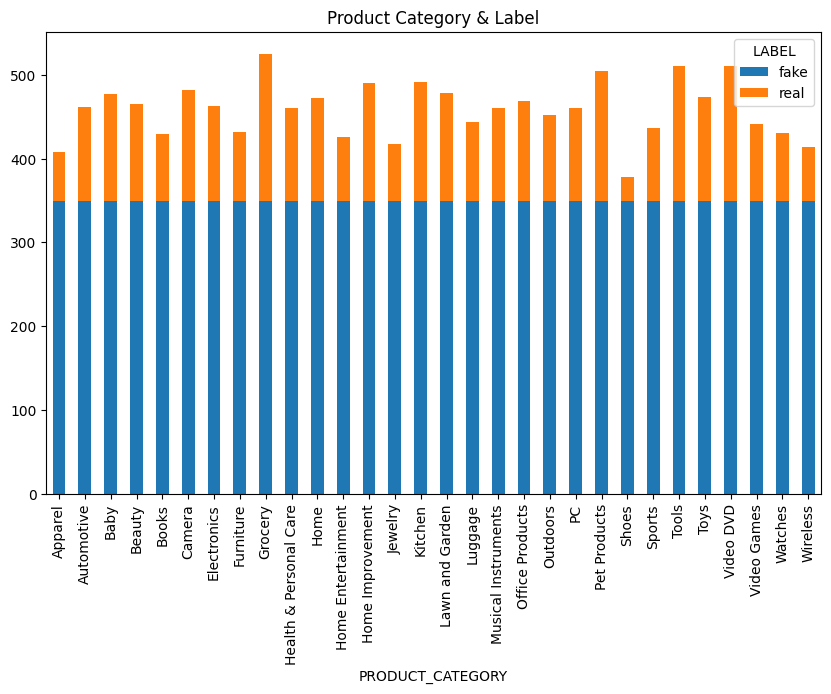

In [ ]:

label_distrubtion_by_product_category = review_df.groupby("PRODUCT_CATEGORY")["LABEL"].value_counts().unstack(fill_value=0)
label_distrubtion_by_product_category.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Product Category & Label")
plt.show()

### WordCloud Generation for `REVIEW_TEXT`

In [ ]:
from pathlib import Path
SCRIPT_DIR/Path('main')

PosixPath('/content/Spam-Review-Analysis/scripts/main')

In [ ]:
# Generate Word Tokens and Analyse the Review Texts
import sys
from pathlib import Path
sys.path.append(SCRIPT_DIR)
sys.path.append(SCRIPT_DIR/Path('main'))

from preprocess import preprocess_text

# Real Tokenized Reviews
real_tokenized_reviews = [item for sublist in \
 (review_df[review_df["LABEL"] == "real"]["REVIEW_TEXT"].apply(lambda text: preprocess_text(text, ngrams=1)).to_list()) \
                          for item in sublist]


# Fake Tokenized Reviews
fake_tokenized_reviews = [item for sublist in \
 (review_df[review_df["LABEL"] == "fake"]["REVIEW_TEXT"].head(10).apply(lambda text: preprocess_text(text, ngrams=1)).to_list()) \
                          for item in sublist]

#### Word Cloud for Real Reviews

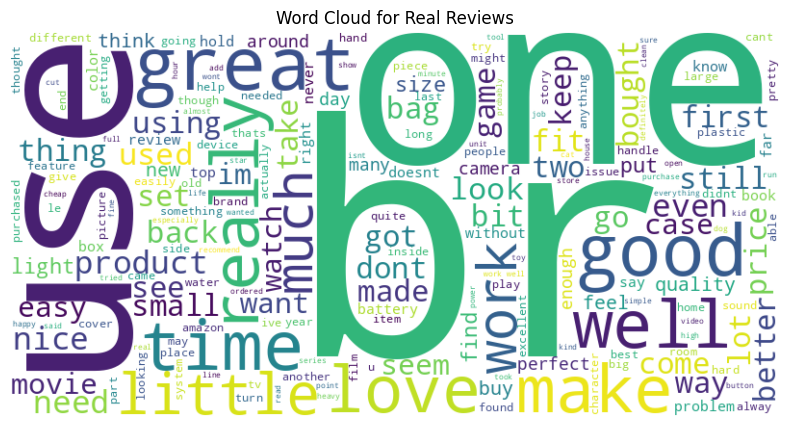

In [ ]:
# Real reviews WordCloud
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(".".join(real_tokenized_reviews))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real Reviews')
plt.show()

#### Word Cloud for Fake Reviews

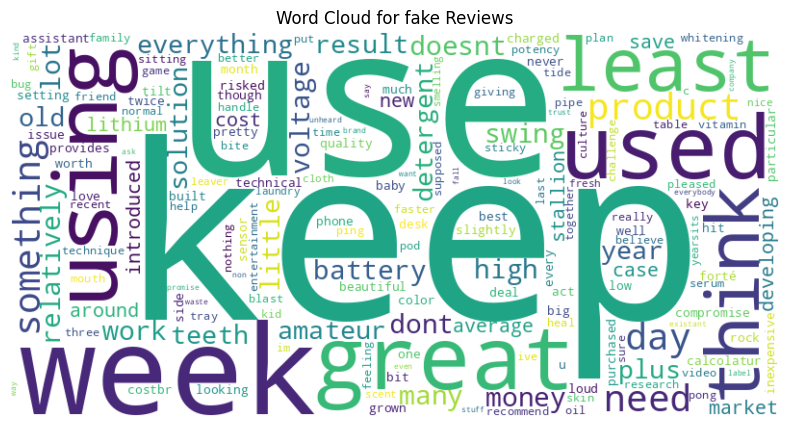

In [ ]:
# Fake reviews on WordCloud
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(".".join(fake_tokenized_reviews))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for fake Reviews')
plt.show()